# Downstream Analysis - R

Now we wrangle our data and plot results! Below, we do this using R tidyverse, cowplot, limma and multcomp packages

In [ ]:
#all_slow
#hide_output
library(tidyverse)
library(cowplot)
library(limma)
library(multcomp)

── Attaching packages ────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




First, we read in results previously generated by py_clone_detector:

In [ ]:
#hide_output
count_df <- read_csv("data/example_results.csv")


── Column specification ───────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  int_img = col_character(),
  seg_ch = col_character(),
  int_img_ch = col_character(),
  seg_img = col_character(),
  GFP_clonepos = col_logical(),
  EC_pos = col_logical(),
  EE_pos = col_logical(),
  preEC_pos = col_logical(),
  ISCorEB_pos = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [ ]:
count_df %>% head()

int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,⋯,centroid-0,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,preEC_pos,ISCorEB_pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,44.05470,89.55212,0.4408815,73.28063,FALSE,2196457,TRUE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,44.05470,89.55212,0.4408815,73.28063,FALSE,52757,TRUE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,44.05470,89.55212,0.4408815,73.28063,FALSE,2262648,TRUE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,44.05470,89.55212,0.4408815,73.28063,FALSE,67331,TRUE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,53.59004,486.79847,0.4652274,98.69063,FALSE,4113516,TRUE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,53.59004,486.79847,0.4652274,98.69063,FALSE,99772,TRUE,FALSE,FALSE,FALSE


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
#hide_output
count_df <- count_df %>%
  mutate(across(is_character, as_factor)) %>%
  filter(int_img_ch == 'C1') %>%
  select(matches("clone$|pos$|int_img")) %>%
  group_by(int_img, GFP_clone) %>%
  summarise(
    EC = sum(EC_pos),
    preEC = sum(preEC_pos),
    EE = sum(EE_pos),
    ISCorEB = sum(ISCorEB_pos)
  ) %>%
  mutate(
    clone_status = if_else(GFP_clone == 0, 'OC', 'IC'),
    genotype = if_else(str_detect(int_img, 'a1'), 'ctrl', 'mut'),
    total = EC + preEC + EE + ISCorEB
  )

ERROR: Error in select(., matches("clone$|pos$|int_img")): unused argument (matches("clone$|pos$|int_img"))


In [ ]:
count_df_tidy <-
  count_df %>% pivot_longer(cols = EC:ISCorEB,
                            names_to = 'cell_type',
                            values_to = 'cell_num') %>%
  mutate(cell_type = factor(cell_type, levels = c('EE', 'EC', 'preEC', 'ISCorEB')))

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `EC` doesn't exist.


In [ ]:
# create stacked bar plots
stacked_bar_mean <- count_df_tidy %>%
  filter(clone_status == 'IC') %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(position = "stack",
           stat = "summary",
           fun = 'mean') +
  scale_fill_manual(values = c("#95a5a6", "#F57171", "#539DC2", "#008b68")) +
  theme(legend.position = "none")

In [ ]:
stacked_bar_percentage <- count_df_tidy %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(position = "fill", stat = 'identity') +
  facet_wrap(vars(clone_status)) +
  scale_fill_manual(values = c("#95a5a6", "#F57171", "#539DC2", "#008b68"))

In [ ]:
# setup plot size, theme and text size
options(repr.plot.width=8, repr.plot.height=4)
theme_set(theme_cowplot(font_size=20))

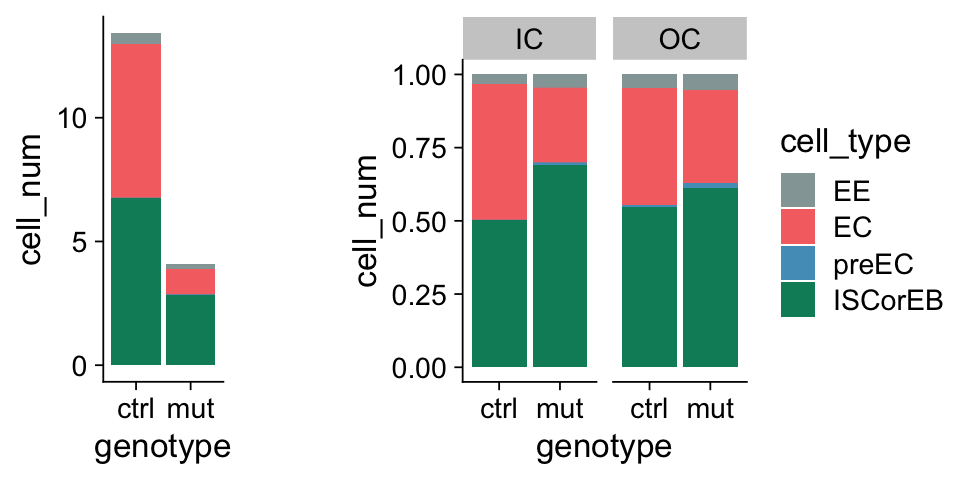

In [ ]:
ggdraw() +
  draw_plot(stacked_bar_mean, x = 0, width = .25) +
  draw_plot(stacked_bar_percentage, x = 0.35, width = .65)

In [ ]:
perc_df_tidy <-
  count_df_tidy %>% mutate(
    perc_cell_num = cell_num / total * 100,
    comp_g_cs_ct = as_factor(paste(genotype, clone_status, cell_type, sep = '_'))
  )

We next setup out desired contrasts using 

In [ ]:
contr <-
  limma::makeContrasts(mut_IC_EC - ctrl_IC_EC, 
                       mut_IC_EE - ctrl_IC_EE,
                       mut_IC_preEC - ctrl_IC_preEC,
                       mut_IC_ISCorEB - ctrl_IC_ISCorEB,
                       mut_OC_EC - mut_IC_EC,
                       mut_OC_EE - mut_IC_EE,
                       mut_OC_preEC - mut_IC_preEC,
                       mut_OC_ISCorEB - mut_IC_ISCorEB,
                       levels = unique(perc_df_tidy$comp_g_cs_ct))

In [ ]:
contrasts(perc_df_tidy$comp_g_cs_ct, how.many = 8) <- contr

In [ ]:
lcon <-seq(8)
names(lcon) <- colnames(contr)
lcon<- lcon %>% as.list()

model <- aov(perc_cell_num ~ comp_g_cs_ct -1, perc_df_tidy)

summary(model, split=list(comp_g_cs_ct=lcon))

                                                   Df  Sum Sq Mean Sq  F value
comp_g_cs_ct                                       16 2662485  166405  324.217
  comp_g_cs_ct: mut_IC_EC - ctrl_IC_EC              1   58190   58190  113.376
  comp_g_cs_ct: mut_IC_EE - ctrl_IC_EE              1       6       6    0.011
  comp_g_cs_ct: mut_IC_preEC - ctrl_IC_preEC        1     721     721    1.406
  comp_g_cs_ct: mut_IC_ISCorEB - ctrl_IC_ISCorEB    1   97751   97751  190.454
  comp_g_cs_ct: mut_OC_EC - mut_IC_EC               1  328239  328239  639.527
  comp_g_cs_ct: mut_OC_EE - mut_IC_EE               1       2       2    0.004
  comp_g_cs_ct: mut_OC_preEC - mut_IC_preEC         1    1445    1445    2.815
  comp_g_cs_ct: mut_OC_ISCorEB - mut_IC_ISCorEB     1  614620  614620 1197.499
Residuals                                        1968 1010083     513         
                                                 Pr(>F)    
comp_g_cs_ct                                     <2e-16 ***
  comp_g_cs